In [1]:
# import os
# os.environ['JAX_PLATFORMS'] = 'cpu'

# This is required to run multiple processes with JAX.
from multiprocessing import set_start_method
set_start_method('spawn', force=True)

In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import geodatasets

import config, data, models, train, evaluate

proj_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/data/distributed")
metadata_dir = proj_dir / "metadata"
basins = gpd.read_file(metadata_dir / 'Ohio_matchups.geojson').set_index("HYBAS_ID")
basins.index = basins.index.astype(str)

basins = basins.to_crs("EPSG:3857")
basins['centroid'] = basins.geometry.centroid

In [3]:
run_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_sr_sl_gs_20250819_134746")

fig_dir = run_dir / "figures" 
fig_dir.mkdir(exist_ok=True, parents=True)

attn_fig_dir = fig_dir / 'attention'
attn_fig_dir.mkdir(exist_ok=True, parents=True)

In [4]:
trainer = train.Trainer.load_last_checkpoint(run_dir)
cfg = trainer.cfg

Model contains 33,149 parameters, using 129.49KB memory.
Creating new Trainer instance...
Logging at /nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_sr_sl_gs_20250819_134746


In [5]:
cfg.quiet = False
cfg.data_subset = 'test'
dataset = data.HydroDataset(cfg)
dataloader = data.HydroDataLoader(cfg, dataset)

Loading graph network file
Loading static attributes
Loading dynamic data
Data Hash: b276fccb0bccc2e09f7b6b931938fb863d54fd920d2264a01fc69e18b2108215
Using cached basin dataset.
Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


In [14]:
y.shape

(16, 1962, 1)

In [13]:
y_pred[:,-1,:,:].shape

(16, 1962, 1)

In [15]:
import jax
import jax.numpy as jnp
import equinox as eqx

explain_model = eqx.tree_at(lambda m: m.return_weights, trainer.model, replace=True)
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, cfg.batch_size)

@eqx.filter_jit
def _model_map(model, batch, keys):
    """Applies the model to a batch of data using jax.vmap."""
    # TODO: If we start training with mixes of different basins we will need to fix this.
    static_keys = ["graph"]
    in_axes_data = {k: (None if k in static_keys else 0) for k in batch}
    in_axes_keys = 0
    y_pred, weights = jax.vmap(model, in_axes=(in_axes_data, in_axes_keys))(batch, keys)
    return y_pred, weights


dates = []
ys = []
y_preds = []
avg_zs = []
for basin, date, batch in tqdm(dataloader, total=len(dataloader)):
    y_pred, weights = _model_map(explain_model, batch, keys)
    y = batch['y'][:,-1,...]
    
    dates.append(date)
    ys.append(np.squeeze(y, axis=-1))
    y_preds.append(np.squeeze(y_pred[:,-1,:,:], axis=-1))
    avg_zs.append(np.mean(weights['z'][:,-1,...], axis=-1))
    

# Create MultiIndex from Cartesian product of time and location
date_1d = np.concatenate(dates, axis=0)
site_1d = basin[0] # Always the same basin order for graph models
index = pd.MultiIndex.from_product(
    [date_1d, site_1d],
    names=["date", "basin"]
)
# Flatten the data into 1D arrays (row-major order)
y_1d = np.concatenate(ys, axis=0).reshape(-1)
y_pred_1d = np.concatenate(y_preds, axis=0).reshape(-1)
avg_z_1d = np.concatenate(avg_zs, axis=0).reshape(-1)

# Create the DataFrame
df = pd.DataFrame({
    "y": y_1d,
    "y_pred": y_pred_1d,
    "z": avg_z_1d,
}, index=index)

df['rel_change'] = df['y_pred'].groupby('basin').transform(lambda x: np.log10(x / x.median()))

100%|██████████| 108/108 [09:47<00:00,  5.44s/it]
/nas/cee-water/cjgleason/ted/swot-ml/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/nas/cee-water/cjgleason/ted/swot-ml/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/nas/cee-water/cjgleason/ted/swot-ml/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/nas/cee-water/cjgleason/ted/swot-ml/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/nas/cee-water/cjgleason/ted/swot-ml/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid 

<Axes: >

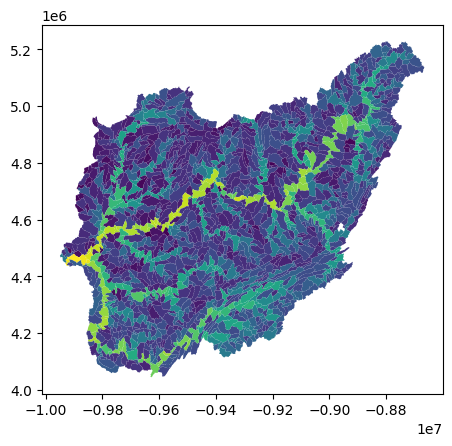

In [16]:
mean_q = df.groupby('basin').mean()

basins.join(mean_q).plot('y_pred')

In [190]:
import pickle
with open(run_dir / 'test_data.pkl', 'rb') as f:
    results, bulk_metrics, basin_metrics = pickle.load(f)
    
results = results['pred']['discharge']

In [24]:
rel_change = results.groupby('basin').transform(lambda x: np.log10(x / x.median()))

NameError: name 'results' is not defined

In [25]:
df['rel_change']

date        basin     
2024-01-03  7090612640   -0.021672
            7090612370   -0.008587
            7090612290    0.387564
            7090610840   -1.344175
            7090610750    0.016488
                            ...   
2024-07-21  7090488880         NaN
            7090490100    0.212762
            7090490270    0.641733
            7090493650    0.172072
            7090493710    0.240829
Name: rel_change, Length: 3390336, dtype: float32

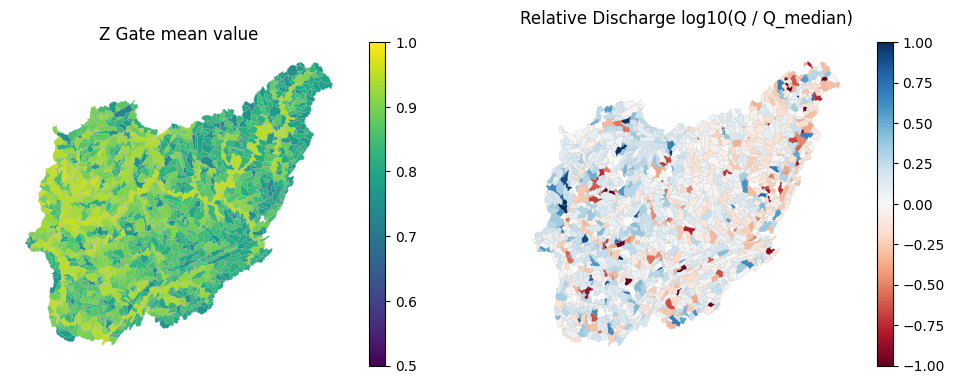

In [26]:
from matplotlib.animation import FuncAnimation, FFMpegWriter


# --- Create the new plot ---
fig, axes = plt.subplots(1,2, figsize=(12, 6))

z_cmap='viridis'
z_norm = plt.Normalize(vmin=0.5, vmax=1.0)
z_sm = plt.cm.ScalarMappable(cmap=z_cmap, norm=z_norm)
z_sm.set_array([])
fig.colorbar(z_sm, ax=axes[0], shrink=0.7)

q_cmap='RdBu'
q_norm = plt.Normalize(vmin=-1, vmax=1.0)
q_sm = plt.cm.ScalarMappable(cmap=q_cmap, norm=q_norm)
q_sm.set_array([])
fig.colorbar(q_sm, ax=axes[1], shrink=0.7)


dates = pd.date_range('2023-01-01', periods=365)


# Animation update function
def update(frame_date):
    date_gdf = basins.join(df.xs(frame_date, level='date'))
    axes[0].clear()
    date_gdf.plot('z', edgecolor='darkgrey', cmap=z_cmap, norm=z_norm, linewidth=0.1, ax=axes[0])
    axes[0].set_axis_off()
    axes[0].set_title('Z Gate mean value')

    # date_rel = basins.join(rel_change.xs(frame_date, level='date'))
    axes[1].clear()
    # date_gdf.plot('y_pred', edgecolor='darkgrey', cmap=q_cmap, linewidth=0.1, ax=axes[1])
    date_gdf.plot('rel_change', edgecolor='darkgrey', cmap=q_cmap, norm=q_norm, linewidth=0.1, ax=axes[1])
    axes[1].set_axis_off()
    axes[1].set_title("Relative Discharge log10(Q / Q_median)")

update(dates[-1])
    
# anim = FuncAnimation(fig, update, frames=dates, repeat=False)
# # Save using ffmpeg
# # May change in future. Use `module spider ffmpeg` load one, and then `which ffmpeg` to find it.
# ffmpeg_path = "/modules/spack/packages/linux-ubuntu24.04-x86_64_v3/gcc-13.2.0/ffmpeg-7.0.2-hpqh7mjhtopager73y4223ini6rzot3o/bin/ffmpeg"
# mpl.rcParams['animation.ffmpeg_path'] = ffmpeg_path
# writer = FFMpegWriter(fps=7, bitrate=6000)
# anim.save(fig_dir / "2023_z_weights.mp4", writer=writer)

In [103]:
df

y       y_pred         z  rel_change
date       basin                                            
2022-03-26 7090569550 NaN  1170.631592  0.964196   -0.178131
           7090568540 NaN  1592.455444  0.958201   -0.004909
           7090568470 NaN     5.583161  0.634601    0.318693
           7090567000 NaN  2525.750244  0.965019    0.181110
           7090566880 NaN     3.079128  0.643351    0.100994
...                    ..          ...       ...         ...
2024-07-04 7090346690 NaN     3.774468  0.740103    0.300879
           7090353550 NaN     3.833364  0.664499   -0.076944
           7090353490 NaN     2.382090  0.716984   -0.130406
           7090354040 NaN     1.638147  0.750308   -0.180844
           7090354030 NaN     2.229072  0.755754    0.020987

[3067904 rows x 4 columns]